### PFSS modeling with pfsspy

Sam Badman - 8/25/22

This notebook goes through running a potential field source surface (PFSS, [1](https://ui.adsabs.harvard.edu/abs/1969SoPh....9..131A/abstract),[2](https://ui.adsabs.harvard.edu/abs/1969SoPh....6..442S/abstract)) model of the solar coronal magnetic field using pfsspy and accessing its components including tracing fieldlines, creating a map of coronal holes and flying a model spacecraft through it and tracing field line connections

Read more about pfsspy here : https://pfsspy.readthedocs.io/en/stable/ and view the source code here : https://github.com/dstansby/pfsspy/tree/0c5b78a2901c5dd55ddc286ba25a91717e85a40c

In [1]:
import pfsspy, sunpy, astropy, matplotlib, numpy
for module in [pfsspy,sunpy,astropy,matplotlib,numpy] :
    print(module.__name__, module.__version__)

pfsspy 1.1.2
sunpy 4.0.4
astropy 5.1
matplotlib 3.5.3
numpy 1.23.2


In [2]:
# Generic imports
import matplotlib.pyplot as plt
import numpy as np

### 1) Downloading a magnetogram

The basic ingredient we need for a PFSS model is a boundary condition of the solar magnetic field at the photosphere. To work, these should be FITS files which are binned in longitude vs latitude over 360 degrees and -90 - +90 degrees respectively. There are many possible options (GONG,WSO,ADAPT,...). Here we show how to download an ADAPT-GONG magnetogram. 

ADAPT reference : (Arge et al. [2010](https://ui.adsabs.harvard.edu/abs/2010AIPC.1216..343A/abstract))

ADAPT-GONG maps for a given year are located in the directory tree (here shown for 2021) : 

`https://gong.nso.edu//adapt/maps/gong/2021/`  

and there are compressed FITS files every 2 hours with file names like :

`adapt40311_03k012_202103300800_i00005700n1.fts.gz`

where the main thing we are interested in changing is the date and time. For this example, the map is for 2021/3/30 at 0800UT. Files exist for each day for hours `0000,0200,0400... 2200` 

You could just go to the url above and double click the file to download the one you want. We can do it also form command line with `wget`, for example :

`wget ftp://gong.nso.edu//adapt/maps/gong/2021/adapt40311_03k012_202103300800_i00005700n1.fts.gz -P ./`

where the last argument is the location on your computer you want to save (here the same location you are running this notebook). We can do this from python (at least in a UNIX environment):


In [3]:
import os
filename = "adapt40311_03k012_202103300800_i00005700n1.fts.gz"
remote_path = "ftp://gong.nso.edu//adapt/maps/gong/2021"
local_path = "."
if not os.path.exists(f"{local_path}/{filename}") : # check if file has already been downloaded
    print(f"Downloading {local_path}/{filename}") 
    os.system(f'wget {remote_path}/{filename} -P {local_path}')
else : print(f"{local_path}/{filename} already exists!" )

./adapt40311_03k012_202103300800_i00005700n1.fts.gz already exists!


### 2) Loading and plotting the magnetogram

Next, import pfsspy and sunpy, make sure they have been installed already

`!pip install pfsspy`

`!pip install sunpy`

In [4]:
import pfsspy
import sunpy.map

Here is a function that reads in ADAPT maps and loads them into a PFSS model

In [5]:
def adapt2pfsspy(filepath, #must already exist on your computer
                 rss=2.5, # Source surface height
                 nr=60, # number of radial gridpoiints for model
                 realization="mean", #which slice of the adapt ensemble to choose
                 return_magnetogram = False # switch to true for function to return the input magnetogram
                ):

    # Load the FITS file into memory
    # ADAPT includes 12 "realizations" - model ensembles
    # pfsspy.utils.load_adapt is a specific function that knows
    # how to handel adapt maps
    adaptMapSequence = pfsspy.utils.load_adapt(filepath)
    # If realization = mean, just average them all together
    if realization == "mean" : 
        br_adapt_ = np.mean([m.data for m in adaptMapSequence],axis=0)
        adapt_map = sunpy.map.Map(br_adapt_,adaptMapSequence[0].meta)
    # If you enter an integer between 0 and 11, the corresponding
    # realization is selected
    elif isinstance(realization,int) : adapt_map = adaptMapSequence[realization]
    else : raise ValueError("realization should either be 'mean' or type int ") 
    
    # pfsspy requires that the y-axis be in sin(degrees) not degrees
    # pfsspy.utils.car_to_cea does this conversion
    adapt_map_strumfric = pfsspy.utils.car_to_cea(adapt_map)

    # Option to return the magnetogram
    if return_magnetogram : 
        return adapt_map_strumfric
    # Otherwise run the PFSS Model and return
    else :
        adapt_map_input = sunpy.map.Map(adapt_map_strumfric.data/1e5,
                                        adapt_map_strumfric.meta)
        peri_input = pfsspy.Input(adapt_map_input, nr, rss)
        peri_output = pfsspy.pfss(peri_input)
        return peri_output


First, run with the option to return the magnetogram to see what the input is

In [6]:
filepath = f"{local_path}/{filename}"
adapt_magnetogram = adapt2pfsspy(filepath,return_magnetogram=True)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs,dsun_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs,dsun_obs
 [sunpy.map.mapbase]


What we receive here is a `sunpy.map.Map` object, which has it's own plot method defined:

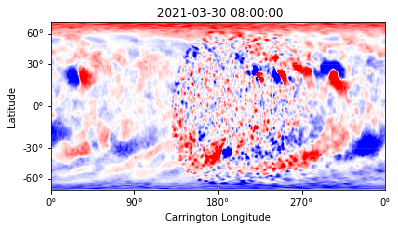

In [7]:
adapt_magnetogram.plot(cmap="bwr",vmin=-10, vmax=10)

What we have here is a map of the radial component of the Sun's magnetic field at the photosphere as a function of longitude and latitude (i.e. covering the whole Sun). 

The blue colors are negative polarity where the field lines point into the sun, and the red where they point outwards. You'll notice strong field in the North and South poles, which is a distinct feature of solar minimum. You'll also notice a boundary surrounding sharper looking data inside and smoother data outside. This is a property of ADAPT whic assimilates recent "measured" data (the sharp resolution region) from the Earth facing part of the disk, and models the rest of the sun with what's called a surface flux transport model. That model applied to the data smooths out the structures.

### 3) Running the PFSS Model

This magnetogram above is what drives a PFSS model, as a boundary condition at the inner boundary. At the outer boundary, the model states that the magnetic field should be radially oriented at a spherical boundary called the "source surface". All that is needed to specify this is the radius of this surface, called the source surface height, or $R_{SS}$. The canonical value ([Hoeksema 1984](https://ui.adsabs.harvard.edu/abs/1984PhDT.........5H/abstract)) is 2.5$R_\odot$. 

Let's run the PFSS model for our downloaded map and this canonical value

In [8]:
pfss_model = adapt2pfsspy(filepath,rss=2.5)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs,dsun_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs,dsun_obs
 [sunpy.map.mapbase]


This has produced a `pfsspy.Output` object (see https://pfsspy.readthedocs.io/en/stable/api/pfsspy.Output.html ). This is essentially, the coronal magnetic field vector on a 3D grid between $1R_\odot$ and $R_{SS}$ with some methods built on top of it. 

### 4) Magnetic Field Line Tracing

One of these which is extremely useful is a field line tracing method. We can use this to trace field lines all over the Sun as follows.

In [9]:
# We're going to need some stuff from the astropy library
import astropy.coordinates
import astropy.units as u

In [10]:
# Define function which does the field line tracing
def pfss2flines(pfsspy_output, # pfsspy output object
                nth=18,nph=36, # number of tracing grid points
                rect=[-90,90,0,360], #sub-region of sun to trace (default is whole sun)
                trace_from_SS=False, # if False : start trace from photosphere, 
                                     #if True, start tracing from source surface
                skycoord_in=None, # Use custom set of starting grid poitns
                max_steps = 1000 # max steps tracer should take before giving up
                ) :
    
    # Tracing if grid
    if skycoord_in is None  :
        [latmin,latmax,lonmin,lonmax]=rect
        lons,lats = np.meshgrid(np.linspace(lonmin,lonmax,nph),
                                np.linspace(latmin,latmax,nth)
                                )
        if not trace_from_SS : alt = 1.0*u.R_sun # Trace up from photosphere
        else : alt = po.grid.rss*u.R_sun  # Trace down from ss
        alt = [alt]*len(lons.ravel())
        seeds = astropy.coordinates.SkyCoord(lons.ravel()*u.deg,
                               lats.ravel()*u.deg,
                               alt,
                               frame = pfsspy_output.coordinate_frame)
        
    # Tracing if custom set of points
    else : 
        skycoord_in.representation_type = "spherical"
        seeds = astropy.coordinates.SkyCoord(skycoord_in.lon,
                               skycoord_in.lat,
                               skycoord_in.radius,
                               frame = pfsspy_output.coordinate_frame)
        
    return pfsspy_output.trace(pfsspy.tracing.FortranTracer(max_steps=max_steps),seeds)

In [11]:
# Run it on the default grid, starting from the photosphere
flines = pfss2flines(pfss_model)

### 5) Visualizing the Output

Now we can make our first plot of the Sun's magnetic field!

Text(0.5, 0.92, 'PFSS - file=adapt40311_03k012_202103300800_i00005700n1.fts.gz - rss=2.5Rs')

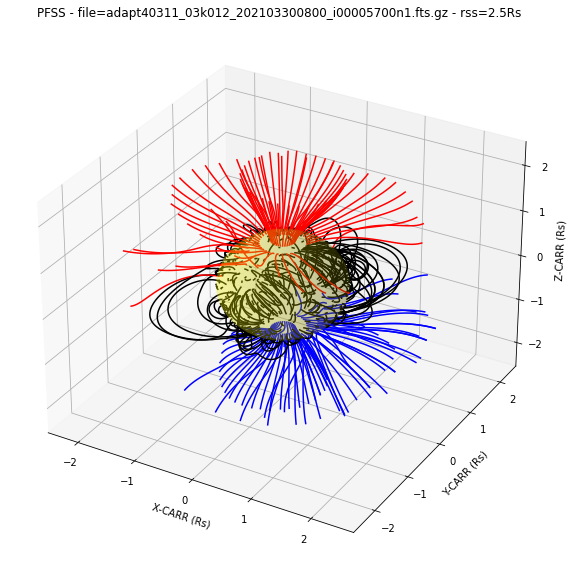

In [12]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

# Make a fake sphere to represent the Sun
lonm,latm = np.meshgrid(np.linspace(0,360,180)*u.deg,
                        np.linspace(-90,90,90)*u.deg)
xm,ym,zm = np.cos(latm)*np.cos(lonm),np.cos(latm)*np.sin(lonm),np.sin(latm)
ax.plot_surface(xm,ym,zm,alpha=0.2,color="yellow")

color_dict = {-1:"blue",0:"black",1:"red"}
for f in flines :
    fcoords = f.coords
    fcoords.representation_type="cartesian"
    ax.plot(fcoords.x.to("R_sun"),
            fcoords.y.to("R_sun"),
            fcoords.z.to("R_sun"),
            color = color_dict.get(f.polarity)
           )
ax.set_xlabel("X-CARR (Rs)")
ax.set_ylabel("Y-CARR (Rs)")
ax.set_zlabel("Z-CARR (Rs)")

ax.set_title(f"PFSS - file={os.path.basename(filename)} - rss=2.5Rs")

We have 3 types of field lines identified here. Red and blue are "open" meaning one end touches the photosphere and the other the source surface, and refer to positive and negative polarity respectively (vector away from or towards the Sun). Both allow solar plasma to freely travel outwards to contribute to the solar wind.

Black field lines are "closed" meaning both ends of the field line touch the photosphere and trap plasma.

Note that here the closed field lines are concentrated around the equator, while the open field lines come from the north and south poles - this is the standard picture around solar minimum.

### 6) Coronal Hole Mapping

Now that we know how to trace field lines through the model, we can ask the question: "Where on the Sun are the open field lines coming from?" The answer is from "coronal holes", which are regions of the Sun's surface which appear dark in EUV. See for example https://stereo-ssc.nascom.nasa.gov/browse/2021/03/30/ 

To do this, we repeat the tracing but at a much higher resolution, and record which field lines are open and which are closed.

In [13]:
flines_highres = pfss2flines(pfss_model,nth=181,nph=361)

The field line topology is defined by the "polarity" attribute of each field line.

In [14]:
topologies = flines_highres.polarities.reshape([181,361])

We can now plot the open/closed contours as a colormap

Text(0.5, 1.0, 'Coronal Hole Map - file=adapt40311_03k012_202103300800_i00005700n1.fts.gz - Rss=2.5Rs')

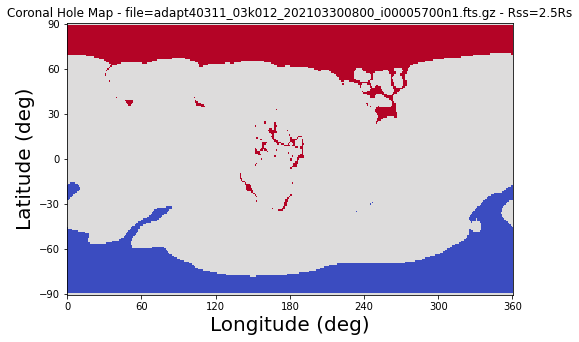

In [15]:
lons = np.linspace(0,360,361)
lats = np.linspace(-90,90,181)
fig,ax = plt.subplots(figsize=(8,5))
ax.pcolormesh(lons,lats,topologies,cmap="coolwarm")
ax.set_xlabel("Longitude (deg)",fontsize=20)
ax.set_ylabel("Latitude (deg)",fontsize=20)
ax.set_xticks(np.linspace(0,360,7))
ax.set_yticks(np.linspace(-90,90,7))
ax.set_title(f"Coronal Hole Map - file={filename} - Rss=2.5Rs")

As expected, the positive open field lines (red) come from the norther latitudes, and the negative open field lines (blue), come from the southern latitudes

### 7) Flying PSP through the model

Lastly, let's look at an example of drawing connections between points on the Sun with a heliospheric spacecraft.

This requires 3 steps :

1) Produce the spacecraft trajectory in a frame that moves with the Sun

2) Project the trajectory down to 2.5Rs using the Parker Spiral

3) Draw field lines through the PFSS model from this projected trajectory. 

#### Preferred solution (actively maintained library) but currently broken as kernels missing from psp website 

For step 1 we will use [astrospice](https://github.com/astrospice/astrospice). You can see a more complete explanation of what we're doing here in this notebook : https://github.com/STBadman/PublicProjects/blob/master/Visualizations/PlottingSpacecraftTrajectoriesAstrospice.ipynb 

We will use the final cell in that notebook, which produces an `astropy.coordinates.SkyCoord` object containing the PSP trajectory at specified timestamps.

We need the astropspice library 

`!pip install astrospice`

and the built in `datetime` library.

and the `sunpy.coordinates` library

In [16]:
import astrospice
import datetime

# Load in PSP Spice Kernels (download happens automatically)
kernels = astrospice.registry.get_kernels('psp','predict') 

# Generate a list of timestamps to generate the spacecraft positions at
timestamps = [datetime.datetime(2021,3,1)+datetime.timedelta(hours=d) 
              for d in range(60*24)
             ] 

# Create the coordinates. We need the spice string "SOLAR PROBE PLUS"
# This produces 
psp_coords_inertial = astrospice.generate_coords('SOLAR PROBE PLUS',timestamps)

# Transform to Heliographic Carrington, i.e. the frame that co-rotates with the Sun.
psp_coords_carr = psp_coords_inertial.transform_to(
    sunpy.coordinates.HeliographicCarrington(observer="self")
)

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

#### Alternative version - heliopy - not actively maintained.  

This backup version uses [heliopy](https://github.com/heliopython/heliopy/tree/main/heliopy) which is no longer actively developed but contains a lot of useful functionality. It works right now because it pulls kernels directly from NAIF rather than the PSP website which seems to be less stable.

`!pip install heliopy`

It is unfortunately a bit more verbose than the astrospice solution. These instructions are cribbed together from https://github.com/STBadman/PublicProjects/blob/master/Visualizations/Orbital_Trajectories.ipynb

Next, visualize the trajectory

Text(0, 0.5, 'Y-CARR (R_sun)')

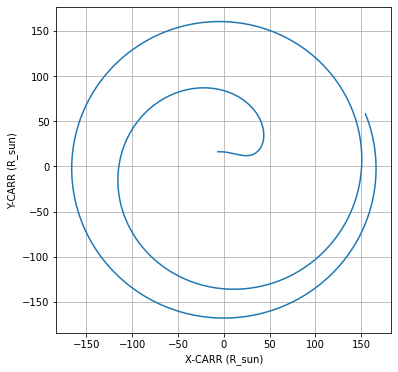

In [17]:
fig,ax=plt.subplots(figsize=(6,6))
unit = "R_sun"

psp_coords_carr.representation_type="cartesian" # set to spherical to access radius, lat and lon

ax.plot(psp_coords_carr.x.to(unit),psp_coords_carr.y.to(unit))
ax.grid()

ax.set_xlabel(f"X-CARR ({unit})")
ax.set_ylabel(f"Y-CARR ({unit})")

Now onto step 2, Parker spiral projection. 

We want to go from PSP's location out in the heliosphere down close to the Sun so that we can trace the field lines through the PFSS model. To do this we assume the connection is a Parker spiral, and what that means in practice is that we only correct longitude and radius, the latitude remains fixed. See figures in [Badman+2020](https://ui.adsabs.harvard.edu/abs/2020ApJS..246...23B/abstract) for some images of what this looks like for PSP's trajectory 

The functional form of the Parker spiral is quite simple :

$$
\begin{align} 
    B_R(R,\theta,\phi) &= B(R_0,\theta,\phi_0) \bigg(\frac{R_0}{R}\bigg)^2 \label{intro:eqn:parkerfield1} \\
    B_\theta(R,\theta,\phi) &= 0 \label{intro:eqn:parkerfield2} \\
    B_\phi(R,\theta,\phi) &= -B(R_0,\theta,\phi_0) \frac{\Omega_{\odot} R_0}{V_{SW}}\frac{R_0}{R}\sin\theta \label{intro:eqn:parkerfield3}
\end{align}
$$

with $\Omega_\odot$ representing the solar rotation rate with respect to the stars, and $V_{SW}$ representing the solar wind velocity. 

For a fixed solar wind speed the longitudinal offset for the spiral connecting points at radii $r_0$ and $r_1$ is also easy to write dwn as :

$$
\Delta \phi = \omega_\odot (r_1 - r_0)/V_{SW}
$$

so in python, making the projection is quite easy:

In [18]:
# Define function to do the longitudinal correction
def delta_long(r,vsw=360.*u.km/u.s,omega_sun=14.713*u.deg/u.d,rss=2.5):
    return omega_sun * (r - rss * u.R_sun) / vsw

rss = 2.5*u.R_sun
psp_coords_carr.representation_type = "spherical"
psp_at_source_surface = astropy.coordinates.SkyCoord(
    radius = rss * np.ones(len(psp_coords_carr)),
    ## The projection can also take a varying solar wind speed as an input
    lon = psp_coords_carr.lon + delta_long(psp_coords_carr.radius,rss=rss.value),
    lat = psp_coords_carr.lat,
    frame = sunpy.coordinates.HeliographicCarrington(observer="self")
)

To compare, we can plot the trajectory latitude and longitude for both the original spacecraft coordinates, and the projected version.

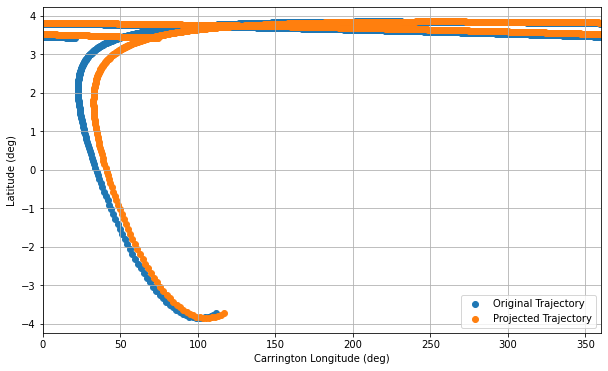

In [19]:
fig,ax = plt.subplots(figsize=(10,6))

psp_coords_carr.representation_type="spherical"
ax.scatter(psp_coords_carr.lon,psp_coords_carr.lat,label="Original Trajectory")
ax.scatter(psp_at_source_surface.lon,psp_at_source_surface.lat,label="Projected Trajectory")

ax.set_xlabel("Carrington Longitude (deg)")
ax.set_ylabel("Latitude (deg)")

ax.set_xlim(0,360)

ax.grid()

ax.legend()

You'll notice a small offset between the blue and orange traces, and at the bottom of the plot the offset decreases as PSP gets closer to the Sun.

We can also visualize the spiral field lines in the equatorial plane:

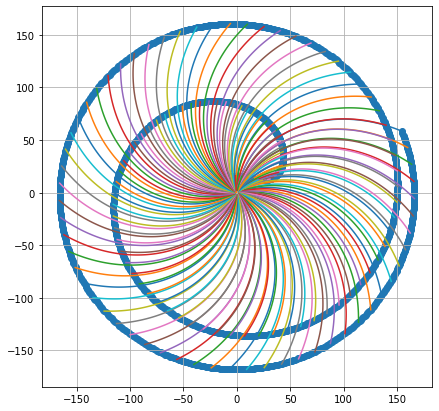

In [20]:
def parker_streamline(phi_0=0.0,r0=1.0,sampling=100,
                      w_s=(2.*np.pi)/(24.47*(24*3600)),
                      v_sw=360e3,rmax=215) :
    # Output r :: Rs, phi :: deg
    r = np.linspace(r0,rmax,sampling)*u.R_sun
    r0 = r0*u.R_sun
    phi = np.degrees(-w_s/v_sw*(r.to("m").value-r0.to("m").value)) + phi_0
    return r.value,phi


psp_at_source_surface.representation_type="spherical"
psp_coords_carr.representation_type="spherical"
spirals = [parker_streamline(phi_0=coord.lon.value,
                             r0=coord.radius.to("R_sun").value,
                             rmax=r_outer.to("R_sun").value
                            ) 
           for coord,r_outer in zip(psp_at_source_surface,psp_coords_carr.radius)
          ]

fig,ax = plt.subplots(figsize=(7,7))

psp_coords_carr.representation_type="cartesian"
ax.scatter(psp_coords_carr.x.to("R_sun"),psp_coords_carr.y.to("R_sun"))

psp_at_source_surface.representation_type="cartesian"
ax.scatter(psp_at_source_surface.x.to("R_sun"),psp_at_source_surface.y.to("R_sun"))

for spiral in spirals[::10] :
    ax.plot(spiral[0]*u.R_sun*np.cos(spiral[1]*u.deg),
            spiral[0]*u.R_sun*np.sin(spiral[1]*u.deg)
           )

ax.grid()



Finally we can do step 3 to trace the field lines from PSP's projected position. This is straightforward to do with the custom coordinates input defined in the field line tracing function above.

In [21]:
flines_psp = pfss2flines(pfss_model, skycoord_in=psp_at_source_surface)

Finally, let's make our visualization of the Sun again but only show the field lines sampled by PSP

Text(0.5, 0.92, 'PFSS - file=adapt40311_03k012_202103300800_i00005700n1.fts.gz - rss=2.5Rs')

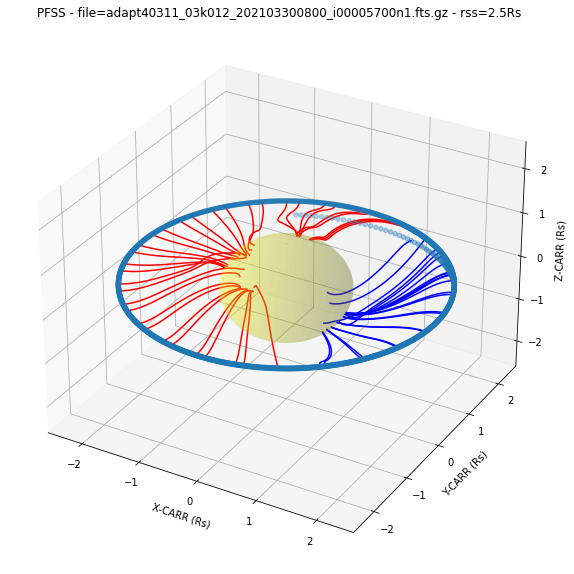

In [22]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

# Make a fake sphere to represent the Sun
lonm,latm = np.meshgrid(np.linspace(0,360,180)*u.deg,
                        np.linspace(-90,90,90)*u.deg)
xm,ym,zm = np.cos(latm)*np.cos(lonm),np.cos(latm)*np.sin(lonm),np.sin(latm)
ax.plot_surface(xm,ym,zm,alpha=0.2,color="yellow")

color_dict = {-1:"blue",0:"black",1:"red"}
for f in flines_psp[::24] :
    fcoords = f.coords
    fcoords.representation_type="cartesian"
    ax.plot(fcoords.x.to("R_sun"),
            fcoords.y.to("R_sun"),
            fcoords.z.to("R_sun"),
            color = color_dict.get(f.polarity)
           )
    
psp_at_source_surface.representation_type="cartesian"
ax.scatter(psp_at_source_surface.x,psp_at_source_surface.y,psp_at_source_surface.z)
    
ax.set_xlabel("X-CARR (Rs)")
ax.set_ylabel("Y-CARR (Rs)")
ax.set_zlabel("Z-CARR (Rs)")

ax.set_xlim([-2.5,2.5])
ax.set_ylim([-2.5,2.5])
ax.set_zlim([-2.5,2.5])

ax.set_title(f"PFSS - file={os.path.basename(filename)} - rss=2.5Rs")

Note the full magnetic connection in this exercise is both the Parker spiral part __and__ the PFSS traced field line part.